In [141]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import matplotlib.pyplot as plt

In [142]:
# Funcion para agregar las señales de MACD
def add_macd_signals(df: pd.DataFrame) -> pd.DataFrame:
    # Compra cuando el MACD cruza al alza su señal
    df['MACD_Buy_Signal_lag1'] = (
        (df['MACD_12_26_9_lag1'] > df['MACDs_12_26_9_lag1']) &
        (df['MACD_12_26_9_lag1'].shift(1) <= df['MACDs_12_26_9_lag1'].shift(1))
    ).astype(int)

    # Venta cuando el MACD cruza a la baja su señal
    df['MACD_Sell_Signal_lag1'] = (
        (df['MACD_12_26_9_lag1'] < df['MACDs_12_26_9_lag1']) &
        (df['MACD_12_26_9_lag1'].shift(1) >= df['MACDs_12_26_9_lag1'].shift(1))
    ).astype(int)

    return df

# Funcion para agregar las señales de Bollinger Bands
def add_bollinger_features(df: pd.DataFrame) -> pd.DataFrame:
    df['BBW_lag1']              = df['BBU_20_2.0_lag1'] - df['BBL_20_2.0_lag1']
    df['BB%B_lag1']             = (df['Close_lag_1'] - df['BBL_20_2.0_lag1']) / (df['BBU_20_2.0_lag1'] - df['BBL_20_2.0_lag1'])
    df['Squeeze_lag1']          = (df['BBB_20_2.0_lag1'] < 0.02).astype(int)
    df['Breakout_lag1']         = (
        (df['Close_lag_1'] > df['BBU_20_2.0_lag1']) |
        (df['Close_lag_1'] < df['BBL_20_2.0_lag1'])
    ).astype(int)
    df['Dist_from_Middle_lag1'] = df['Close_lag_1'] - df['BBM_20_2.0_lag1']
    df['Z_Score_lag1']          = df['Dist_from_Middle_lag1'] / ((df['BBU_20_2.0_lag1'] - df['BBM_20_2.0_lag1']) / 2)
    df['BB_Ratio_lag1']         = df['BBU_20_2.0_lag1'] / df['BBL_20_2.0_lag1']
    return df

# Funcion para agregar las features de lags de SMA, RSI, MACD, Bollinger Bands a partir del Close_lag_1
def add_lag1_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df['Close_lag_1'] = df['Close'].shift(1)

    df['SMA_20']       = ta.sma(df['Close'], length=20)
    df['SMA_20_lag1']  = df['SMA_20'].shift(1)
    df['SMA_50']       = ta.sma(df['Close'], length=50)
    df['SMA_50_lag1']  = df['SMA_50'].shift(1)
    df['RSI_14']       = ta.rsi(df['Close'], length=14)
    df['RSI_14_lag1']  = df['RSI_14'].shift(1)
    df.drop(columns=['SMA_20', 'SMA_50', 'RSI_14'], inplace=True)

    macd = ta.macd(df['Close'])
    df['MACD_12_26_9_lag1']  = macd['MACD_12_26_9'].shift(1)
    df['MACDh_12_26_9_lag1'] = macd['MACDh_12_26_9'].shift(1)
    df['MACDs_12_26_9_lag1'] = macd['MACDs_12_26_9'].shift(1)

    bb = ta.bbands(df['Close'], length=20)
    df['BBL_20_2.0_lag1'] = bb['BBL_20_2.0'].shift(1)
    df['BBM_20_2.0_lag1'] = bb['BBM_20_2.0'].shift(1)
    df['BBU_20_2.0_lag1'] = bb['BBU_20_2.0'].shift(1)
    df['BBB_20_2.0_lag1'] = bb['BBB_20_2.0'].shift(1)
    df['BBP_20_2.0_lag1'] = bb['BBP_20_2.0'].shift(1)

    df = add_bollinger_features(df)
    df = add_macd_signals(df)

    return df

#Funcion para agregar las features de covid
def add_covid_info(df):
    df['days_since_covid_begin'] = (df['Date'] - pd.to_datetime('2020-03-11')).dt.days
    df['days_since_covid_end'] = (df['Date'] - pd.to_datetime('2023-05-05')).dt.days
    return df

#Funcion para agregar las features de estaciones
def add_seasons(df, as_dummies=False):
    month = df['Date'].dt.month
    df['season'] = month.map({
        12: 'Winter', 1: 'Winter', 2: 'Winter',
        3: 'Spring', 4: 'Spring', 5: 'Spring',
        6: 'Summer', 7: 'Summer', 8: 'Summer',
        9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
    })

    if as_dummies:
        season_dummies = pd.get_dummies(df['season'], prefix='season', drop_first=True)
        df = df.drop(columns='season')
        df = pd.concat([df, season_dummies], axis=1)

    return df

def day_month_year(df):
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['day_of_week'] = df['Date'].dt.dayofweek
    return df

#Funcion para agregar las features de lags
def lag_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag_{lag}'] = df[target_col].shift(lag)
    return df

# Funcion para agregar todas las features generadas
def feature_engineering(df):
    print(f"Dataset before feature engineering: {df.shape}")

    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df = add_lag1_technical_indicators(df) #Agregar SMA, RSI, MACD, Bollinger Bands a partir del Close_lag_1
    df = add_covid_info(df) #Agregar features de covid
    df = add_seasons(df, as_dummies=True) #Agregar features de estaciones
    df = day_month_year(df) #Agregar features de dia, mes, año y dia de la semana
    df = lag_features(df, 'Close', list(range(1, 16))) #Agregar features de lags de Close desde 1 hasta 15 dias atras
    
    # Calculamos las features del SP500 del día anterior
    cols_sp500 = [c for c in df.columns if 'SP500' in c and 'Open' not in c]
    for col in cols_sp500:
        df[f'{col}_lag_1'] = df[col].shift(1)
    df.drop(columns=cols_sp500, inplace=True)

    # Calculamos las features del volumen, high y low del día anterior
    cols_prev_data = ['Volume', 'High', 'Low']  
    for col in cols_prev_data:
        df = lag_features(df, col, [1])
    df.drop(columns=cols_prev_data, inplace=True)

    df.dropna(inplace=True)

    #Se dropea date ya que no se necesita para el modelo
    #Cambiar close. Usar el close de la anterior fecha para obtener %Change. Esto sería lo que se busca predecir.
    #Si este ratio es positivo, significa que el precio de la acción va a subir, por lo que se puede comprar.
    #Si el ratio es negativo, significa que el precio de la acción va a bajar, por lo que se puede vender.
    df['ChangeRatio'] = ((df['Close'] - df['Close_lag_1']) / df['Close_lag_1'])*100
    
    #Drop de Close y Date
    df.drop(columns=['Close'], inplace=True)

    print(f"Dataset after feature engineering: {df.shape}")
    return df

In [143]:
def sample_with_time_weights(df, percentage=0.1, k=0.01, plot=True):
        """
        Sample data with exponentially decreasing weights for older data points.
        
        Args:
            df: DataFrame with a 'Date' column
            percentage: Fraction of data to sample
            k: Parameter controlling the exponential decay rate
            plot: Whether to generate plots of the weight distribution
            
        Returns:
            Sampled DataFrame with 'Date' column dropped
        """
        print(f"Dataset before sampling: {df.shape}")
        # Create a copy of the dataframe to avoid SettingWithCopyWarning
        df = df.copy()
        
        # Convertir Date a tipo datetime y ordenar por fecha
        df.loc[:, 'Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values(['Date'], ascending=True)
        
        # Arreglo de distribución de probabilidad. Mientras más lejos este de la fecha más reciente, menos probabilidad tiene de ser traida.
        # Asignamos pesos que van de menor a mayor (más antiguo = menos peso)
        valoresX = [i+1 for i in range(len(df))]
        valoresX = np.array(valoresX)

        distribucion = k*np.exp(-k*valoresX)  # pesos decrecientes

        # Dar la vuelta a la distribución para que los más recientes tengan más peso
        distribucion = distribucion[::-1]
        distribucion = distribucion/distribucion.sum()  # Normalizar la distribución
        distribucion = pd.Series(distribucion, index=df.index)
        
        if plot:
            plt.figure(figsize=(10, 5))
            plt.plot([i for i in range(len(distribucion))], distribucion)
            plt.title('Distribution of weights')
        
        # Se pasa la distribución a una función de selección de datos aleatoria, 
        # el tamaño estará dado por el parametro percentage
        df2 = df.sample(frac=percentage, weights=distribucion, random_state=11)

        # Convertir Date a tipo datetime
        df2.loc[:, 'Date'] = pd.to_datetime(df2['Date'])
        df2 = df2.sort_values(['Date'], ascending=True)
        
        if plot:
            plt.figure(figsize=(10, 5))
            plt.hist(df2['Date'], bins=30)
            plt.title('Histogram of Dates with more weight in recent data')
            
        df2.drop(columns=['Date'], inplace=True)
        
        print(f"Dataset after sampling: {df2.shape}")
        return df2

Dataset before feature engineering: (11165, 11)
Dataset after feature engineering: (11115, 55)
Dataset before sampling: (11094, 55)
Dataset after sampling: (5547, 54)


/tmp/ipykernel_190868/1615087671.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_data_test.drop(columns=['Date'], inplace=True)


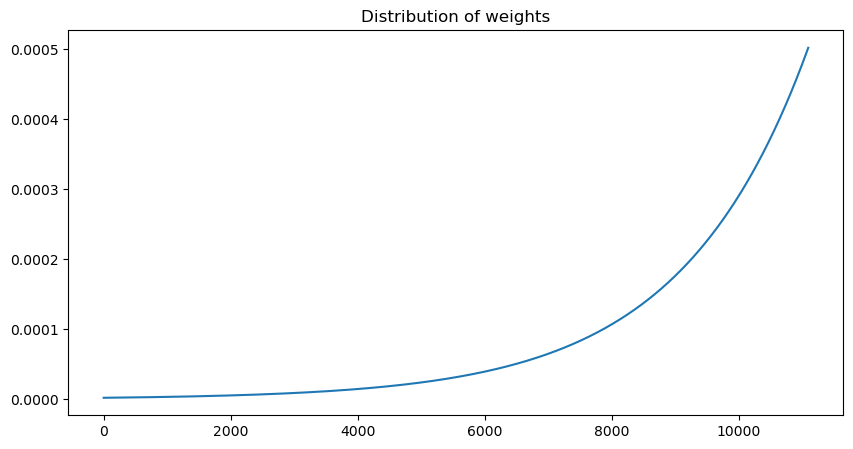

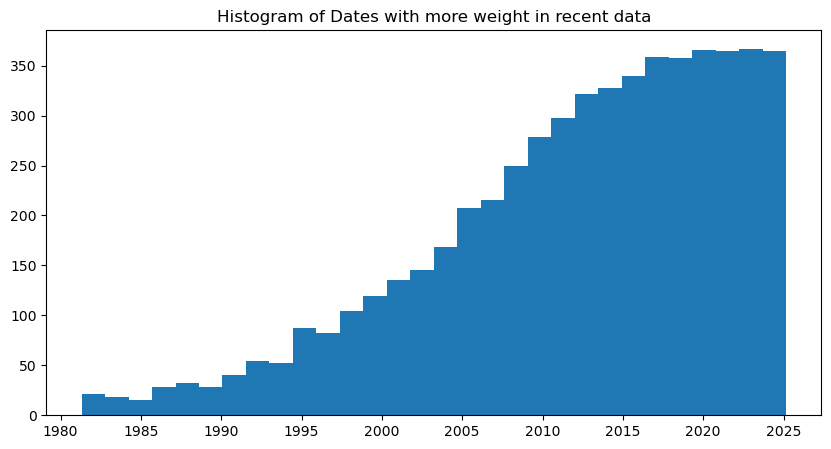

In [144]:
apple_data = pd.read_csv('../data/raw/AAPL_with_SP500.csv')
apple_data = feature_engineering(apple_data)

# Preparar los datos para el entrenamiento y hacer sampling con pesos
apple_data_train = apple_data[apple_data['Date']<='2025-02-28']
apple_data_train = sample_with_time_weights(apple_data_train, percentage=0.5, k=0.0005)

# Preparar los datos para el test
apple_data_test = apple_data[apple_data['Date']>'2025-02-28']
apple_data_test.drop(columns=['Date'], inplace=True)

In [145]:
apple_data_test.to_csv('../data/processed/AAPL_test.csv', index=False)
apple_data_train.to_csv('../data/processed/AAPL_train.csv', index=False)

Regresión lineal para ver a groso modo el resultado del Feature Engineering

MSE: 4.660468472270855
R2: 0.16525531129661075
Predicciones positivas reales: 604
Predicciones positivas predichas: 493
Accuracy: 0.6873873873873874


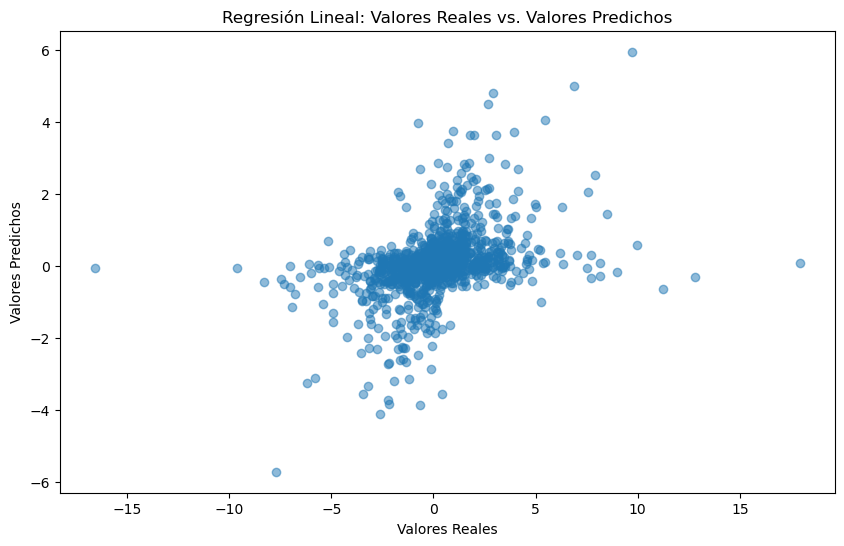

In [146]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Preparar los datos para el entrenamiento
train, valid = train_test_split(apple_data_train, test_size=0.2, random_state=42, shuffle=True)

y_train = train['ChangeRatio']
X_train = train.drop(columns=['ChangeRatio'])

y_valid = valid['ChangeRatio']
X_valid = valid.drop(columns=['ChangeRatio'])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_valid_scaled)

mse = mean_squared_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)  

print(f"MSE: {mse}")
print(f"R2: {r2}")

#Imprimir el numero de predicciones con signo positivo
print(f"Predicciones positivas reales: {np.sum(y_valid > 0)}")
#Imprimir el numero de predicciones con signo negativo
print(f"Predicciones positivas predichas: {np.sum(y_pred < 0)}")

#Obtener el accuracy de las predicciones sumando el acierto de las predicciones positivas y negativas
accuracy = np.sum((y_valid > 0) & (y_pred > 0)) + np.sum((y_valid < 0) & (y_pred < 0))
accuracy = accuracy / len(y_valid)
print(f"Accuracy: {accuracy}")
# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.scatter(y_valid, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal: Valores Reales vs. Valores Predichos')
plt.show()

MSE: 3.5216873591844973
R2: -0.057776373015463456
Predicciones positivas reales: 9
Predicciones positivas predichas: 7
Predicciones negativas reales: 12
Predicciones negativas predichas: 14
Accuracy: 0.5238095238095238


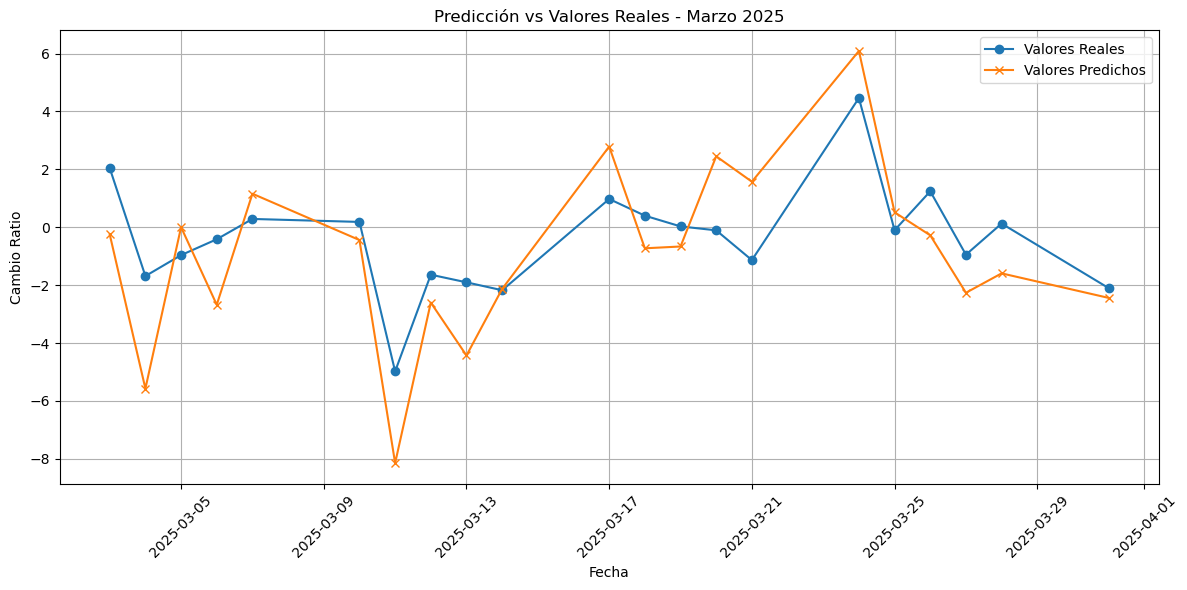

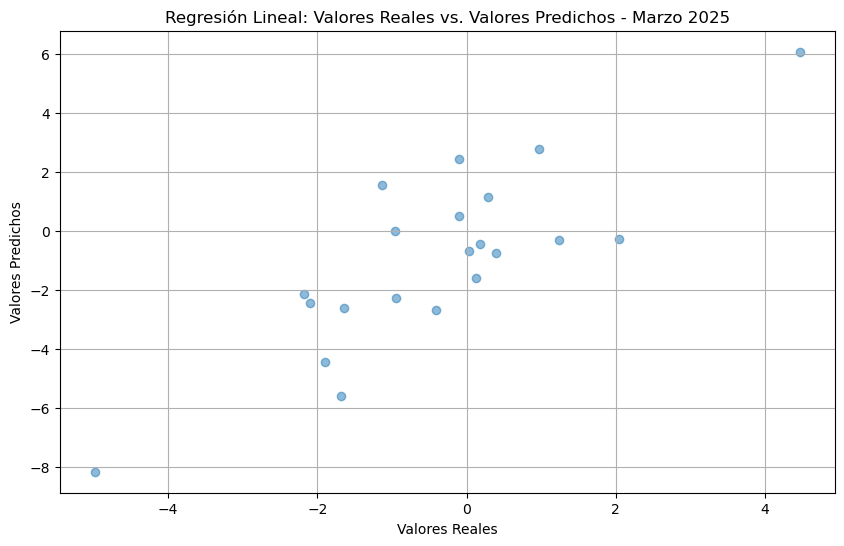

In [147]:
# Cargar los datos de prueba (marzo 2025)
test_data = pd.read_csv('../data/processed/AAPL_test.csv')

# Asegurarse de que tenemos la columna de fecha
apple_data_test_with_date = pd.read_csv('../data/raw/AAPL_with_SP500.csv')
apple_data_test_with_date = apple_data_test_with_date[apple_data_test_with_date['Date'] >= '2025-03-01']
apple_data_test_with_date = apple_data_test_with_date[apple_data_test_with_date['Date'] <= '2025-03-31']

# Preparar datos para predicción
X_test = test_data.drop(columns=['ChangeRatio'])
y_test = test_data['ChangeRatio']
X_test_scaled = scaler.transform(X_test)
y_pred = model.predict(X_test_scaled)

# Métricas de evaluación
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)  
print(f"MSE: {mse}")
print(f"R2: {r2}")

print(f"Predicciones positivas reales: {np.sum(y_test > 0)}")
print(f"Predicciones positivas predichas: {np.sum(y_pred > 0)}")

print(f"Predicciones negativas reales: {np.sum(y_test < 0)}")
print(f"Predicciones negativas predichas: {np.sum(y_pred < 0)}")

accuracy = np.sum((y_test > 0) & (y_pred > 0)) + np.sum((y_test < 0) & (y_pred < 0))
accuracy = accuracy / len(y_test)
print(f"Accuracy: {accuracy}")

# Crear un DataFrame con fechas y valores reales y predichos
result_df = pd.DataFrame({
    'Date': apple_data_test_with_date['Date'].values[:len(y_test)],
    'Real': y_test.values,
    'Predicción': y_pred
})

# Convertir la columna de fecha a datetime
result_df['Date'] = pd.to_datetime(result_df['Date'])

# Graficar los valores reales y predichos a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(result_df['Date'], result_df['Real'], label='Valores Reales', marker='o')
plt.plot(result_df['Date'], result_df['Predicción'], label='Valores Predichos', marker='x')
plt.xlabel('Fecha')
plt.ylabel('Cambio Ratio')
plt.title('Predicción vs Valores Reales - Marzo 2025')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Regresión Lineal: Valores Reales vs. Valores Predichos - Marzo 2025')
plt.grid(True)
plt.show()

Dataset before feature engineering: (7013, 11)
Dataset after feature engineering: (6963, 55)
Dataset before sampling: (6942, 55)
Dataset after sampling: (3471, 54)


/tmp/ipykernel_190868/3266445990.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amzn_data_test.drop(columns=['Date'], inplace=True)


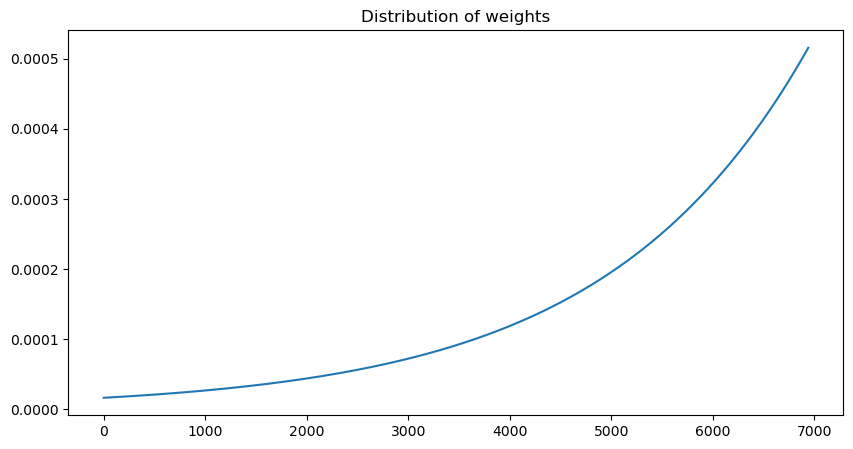

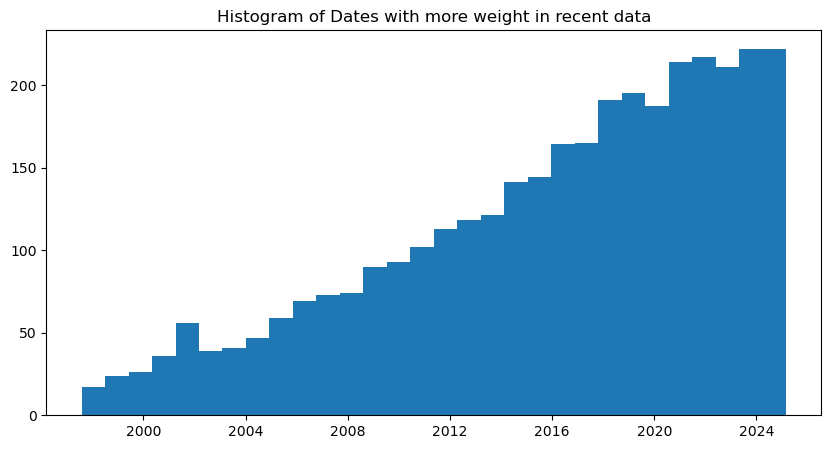

In [148]:
amzn_data = pd.read_csv('../data/raw/AMZN_with_SP500.csv')
amzn_data = feature_engineering(amzn_data)

amzn_data_train = amzn_data[amzn_data['Date'] <= '2025-02-28']
amzn_data_train = sample_with_time_weights(amzn_data_train, percentage=0.5, k=0.0005)

amzn_data_test = amzn_data[amzn_data['Date'] > '2025-02-28']
amzn_data_test.drop(columns=['Date'], inplace=True)
amzn_data_test.to_csv('../data/processed/AMZN_test.csv', index=False)
amzn_data_train.to_csv('../data/processed/AMZN_train.csv', index=False)

Dataset before feature engineering: (5187, 11)
Dataset after feature engineering: (5137, 55)
Dataset before sampling: (5116, 55)
Dataset after sampling: (2558, 54)


/tmp/ipykernel_190868/3203138880.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  googl_data_test.drop(columns=['Date'], inplace=True)


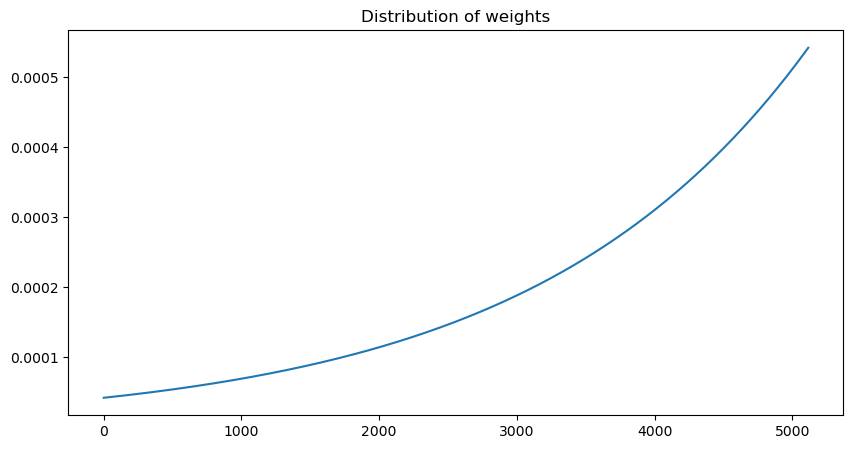

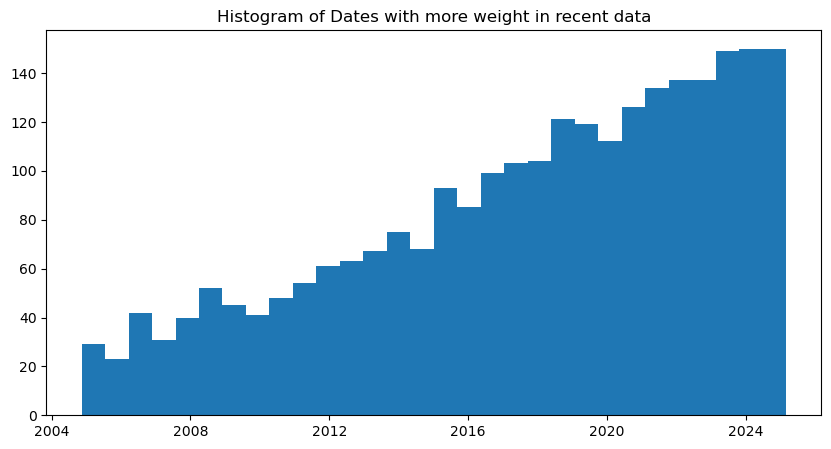

In [149]:

googl_data = pd.read_csv('../data/raw/GOOGL_with_SP500.csv')
googl_data = feature_engineering(googl_data)

googl_data_train = googl_data[googl_data['Date'] <= '2025-02-28']
googl_data_train = sample_with_time_weights(googl_data_train, percentage=0.5, k=0.0005)

googl_data_test = googl_data[googl_data['Date'] > '2025-02-28']
googl_data_test.drop(columns=['Date'], inplace=True)
googl_data_test.to_csv('../data/processed/GOOGL_test.csv', index=False)
googl_data_train.to_csv('../data/processed/GOOGL_train.csv', index=False)

Dataset before feature engineering: (9839, 11)
Dataset after feature engineering: (9789, 55)
Dataset before sampling: (9768, 55)
Dataset after sampling: (4884, 54)


/tmp/ipykernel_190868/4163463566.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msft_data_test.drop(columns=['Date'], inplace=True)


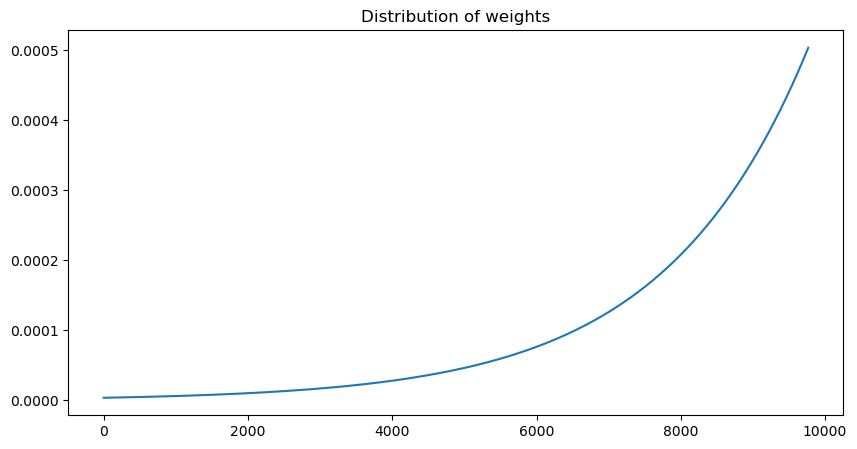

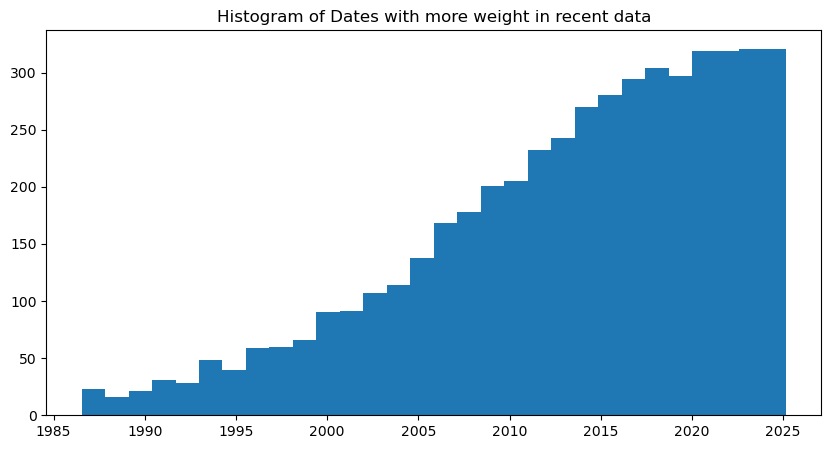

In [150]:
msft_data = pd.read_csv('../data/raw/MSFT_with_SP500.csv')
msft_data = feature_engineering(msft_data)

msft_data_train = msft_data[msft_data['Date'] <= '2025-02-28']
msft_data_train = sample_with_time_weights(msft_data_train, percentage=0.5, k=0.0005)

msft_data_test = msft_data[msft_data['Date'] > '2025-02-28']
msft_data_test.drop(columns=['Date'], inplace=True)
msft_data_test.to_csv('../data/processed/MSFT_test.csv', index=False)
msft_data_train.to_csv('../data/processed/MSFT_train.csv', index=False)

Dataset before feature engineering: (6588, 11)
Dataset after feature engineering: (6538, 55)
Dataset before sampling: (6517, 55)
Dataset after sampling: (3258, 54)


/tmp/ipykernel_190868/88630448.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvda_data_test.drop(columns=['Date'], inplace=True)


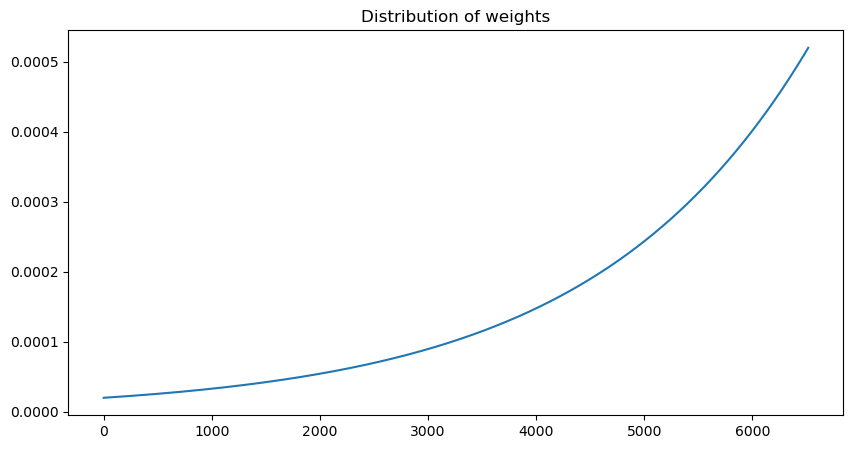

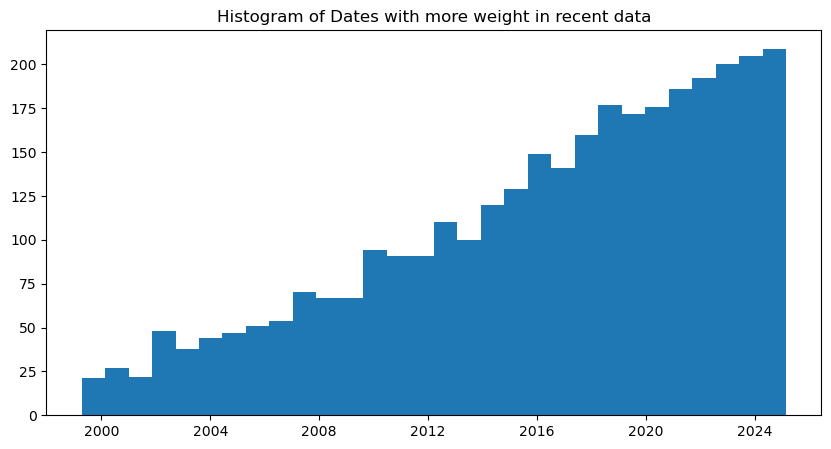

In [151]:
nvda_data = pd.read_csv('../data/raw/NVDA_with_SP500.csv')
nvda_data = feature_engineering(nvda_data)

nvda_data_train = nvda_data[nvda_data['Date'] <= '2025-02-28']
nvda_data_train = sample_with_time_weights(nvda_data_train, percentage=0.5, k=0.0005)

nvda_data_test = nvda_data[nvda_data['Date'] > '2025-02-28']
nvda_data_test.drop(columns=['Date'], inplace=True)
nvda_data_test.to_csv('../data/processed/NVDA_test.csv', index=False)
nvda_data_train.to_csv('../data/processed/NVDA_train.csv', index=False)
